In [16]:
# If external python files are updated
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

import functions

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device used: cpu


# Data preprocessing


### Hyperparameters for data importation

In [17]:
train_size = 0.9                     # In percent
test_size = 1 - train_size           # In percent, calculated dynamically from train_size
batch_size = 16                      # Size of batches

## Import the dataset
Dataset should be imported as a pytorch dataloader for batch optimization

In [18]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for path in folder_paths:
    c = folder_paths.index(path)
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy arrayF
X = np.array(X)

from sklearn.preprocessing import Normalizer
# Transpose to make each image a row
X_flattened = X.reshape(X.shape[0], -1)

# Normalize each row (i.e., each flattened image)
X_flattened = Normalizer().fit_transform(X_flattened)

# Reshape back to the original shape
X = X_flattened.reshape(X.shape)
X = X.reshape(len(X), 128, 128, 1)

# Dynamically calculate the number of classes in dataset
num_classes = len(np.unique(Y))

# Shape of the array
print(np.shape(X))

(6400, 128, 128, 1)


### Split into Test/Training sets

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1 - train_size, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 1 - train_size, stratify=Y_train, random_state=42)

# for i in np.unique(Y_train):
#     print(f"Elements of {i} in X_train: {np.count_nonzero(Y_train == i)}")
# print()
# for i in np.unique(Y_test):
#     print(f"Elements of {i} in X_test: {np.count_nonzero(Y_test == i)}")
# print()
# for i in np.unique(Y_val):
#     print(f"Elements of {i} in X_val: {np.count_nonzero(Y_val == i)}")

In [20]:
from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
from torchvision.transforms import v2

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.Y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# # Define transformations, you can adjust these based on your needs
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Converts to PyTorch tensor
# ])

transformation = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

# Create an instance of your dataset
dataset_train = MyDataset(X=X_train, Y=Y_train, transform=transformation)
dataset_val = MyDataset(X=X_val, Y=Y_val, transform=transformation)
dataset_test = MyDataset(X=X_test, Y=Y_test, transform=transformation)

# Define DataLoader for training, validation and test sets
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

### Show example of dataset

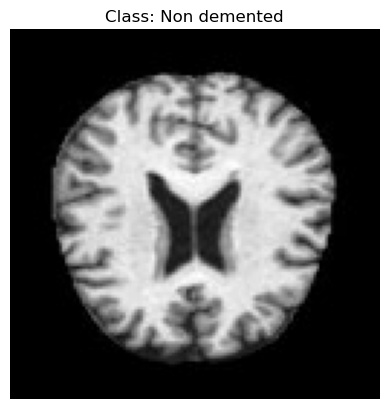

In [21]:
index_to_display = 0  # Image to show in dataset

# Get the image array and corresponding class
selected_image = X[index_to_display]
selected_class = classes[Y[index_to_display]]

# Display the image
plt.imshow(selected_image, cmap='gray')
plt.title(f'Class: {selected_class}')
plt.axis('off')  # Turn off axis labels
plt.show()

## Data augmentation

## Data normalization

# Architecture of the network

### Hyperparameters Network

In [46]:
# training
num_epochs = 20                         # Number of epochs for the training of the nn

# Learning rate und scheduler
initial_learning_rate = 0.01            # Learningrate at start
lr_steps = 20                         # Steps in lr scheduler until lr is updated
lr_gamma = 0.5                          # Faktor the lr is multiplied and updated with

In [47]:
dynamic_model = functions.custom_ConvNet(
    input_channels = 1,
    output_size = num_classes,
    n_conv_layers1 = 2,
    n_filters1 = 5,
    kernel_size1 = 6,
    n_dense_layers = 2,
    n_dense_initial_nodes = 2**6,
    n_conv_layers2 = 0,
    n_filters2 = 0, 
    kernel_size2 = 0,
    operation_and_factor_filter_size=('*', 1),
    operation_and_factor_dense_network=('/', 2),
    dropout_rate=0.1,
    pooling = [2,2],
    activation_function = F.leaky_relu,
    )

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=initial_learning_rate)
lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)

loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist = functions.train_network(dynamic_model, train_loader, criterion, optimizer, num_epochs, lr_scheduler, validation_loader, device)

Size last layer before output: 64
Device used for training: cpu
Epoch [1/20], Step [54/324], Loss: 1.3706
Epoch [1/20], Step [108/324], Loss: 0.9368
Epoch [1/20], Step [162/324], Loss: 0.9797
Epoch [1/20], Step [216/324], Loss: 1.0399
Epoch [1/20], Step [270/324], Loss: 1.0648
Epoch [1/20], Step [324/324], Loss: 1.0446
Epoch [2/20], Step [54/324], Loss: 0.9987
Epoch [2/20], Step [108/324], Loss: 0.9335
Epoch [2/20], Step [162/324], Loss: 0.8744
Epoch [2/20], Step [216/324], Loss: 1.0260
Epoch [2/20], Step [270/324], Loss: 1.1611
Epoch [2/20], Step [324/324], Loss: 1.1546
Epoch [3/20], Step [54/324], Loss: 1.1165
Epoch [3/20], Step [108/324], Loss: 0.9034
Epoch [3/20], Step [162/324], Loss: 0.9315
Epoch [3/20], Step [216/324], Loss: 1.0500
Epoch [3/20], Step [270/324], Loss: 1.0581
Epoch [3/20], Step [324/324], Loss: 1.0508
Epoch [4/20], Step [54/324], Loss: 1.0089
Epoch [4/20], Step [108/324], Loss: 0.9267
Epoch [4/20], Step [162/324], Loss: 1.1378
Epoch [4/20], Step [216/324], Loss: 0

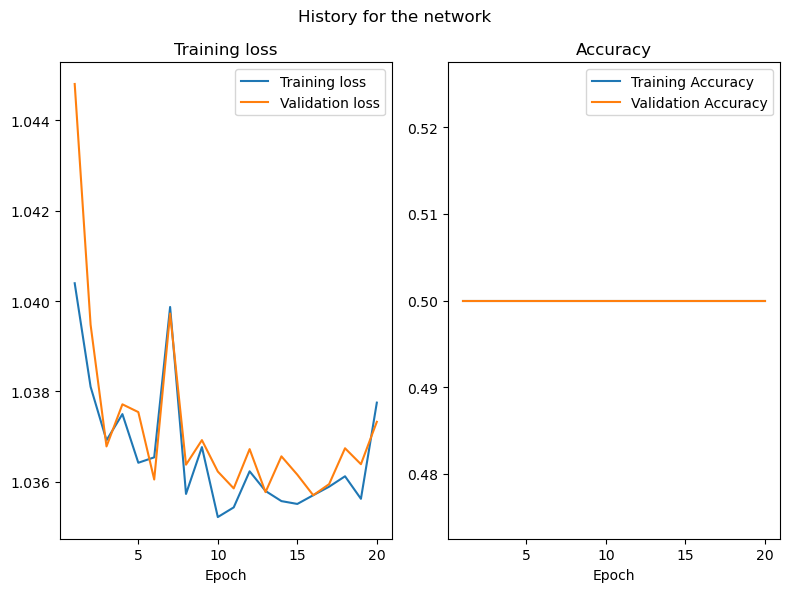

In [48]:
x_epochs = np.linspace(1, num_epochs, num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [25]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, nb_filters, kernel_size_conv, fc_size, fc_out_features, pooling_size = [1, 1], activation_function = F.relu, dropout_rate_conv = 0, dropout_rate_fc = 0, padding = 0, stride = 1):
        '''
        in_channels         : The dimension of colors (grayscale = 1, rbg = 3)
        nb_filters          : Number of filters applied to first layer
        kernel_size_conv    : Size of the convolution of the first layer
        fc_size             : Size of the first fully connected layer (output)
        fc_out_features     : Number of classes of the dataset
        pooling_size        : Pooling size, default = (1,1)
        activation_function : Set the activation function for the layers, default is ReLU
        dropout_rate_cov    : Sets the probability for dropout rates in the convolutional layers , default = 0
        dropout_rate_fc     : Sets the probability for dropout rates in the fully connected layers , default = 0
        padding             : Size of padding that should be applied, default = 0
        stride              : Size of the stride applied of the convolution, default = 1
        '''

        # Define layers in the network
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, nb_filters, kernel_size_conv)
        self.conv2 = nn.Conv2d(nb_filters, 2 * nb_filters, kernel_size_conv)
        self.conv3 = nn.Conv2d(2 * nb_filters,  4 *nb_filters, kernel_size_conv)
        self.conv4 = nn.Conv2d(4 * nb_filters, 8 * nb_filters, kernel_size_conv)
        self.conv5 = nn.Conv2d(8 * nb_filters, 16 * nb_filters, kernel_size_conv)

        self.dropout2d = nn.Dropout2d(p=dropout_rate_conv)
        self.pool = nn.MaxPool2d(pooling_size[0], pooling_size[1])
    
        # Initialize these sizes for the fully connected layer and calculate this dynamically later in the first forward pass
        self.input_size = None                  # Will later be the size of the image input
        self.fc_size_input = None               # Will later be the size of the output of the last cnn layer (after pooling)

        # Dummy values for Linear layers; will be updated in the first forward pass
        self.fc1 = nn.Linear(1, 1)
        self.fc2 = nn.Linear(1, 1)
        self.fc3 = nn.Linear(1, 1)

        # Dropout for fully connected layers
        self.dropout_fc1 = nn.Dropout(p=dropout_rate_fc)
        self.dropout_fc2 = nn.Dropout(p=dropout_rate_fc)

        # Set some variables for the forward pass
        self.activation_function = activation_function
        self.fc_size = fc_size
        self.fc_out_features = fc_out_features
        self.pooling_size = pooling_size
        self.padding = padding
        self.stride = stride

    def forward(self, x):
        # Set the input size dynamically during the first forward pass
        if self.input_size is None:
            self.input_size = x.size(2)
            self.fc_size_input = self.calculate_fc_size(self.conv1.out_channels, self.conv1.kernel_size[0])
            print(self.fc_size_input)
            self.fc1 = nn.Linear(self.fc_size_input, self.fc_size)
            self.fc2 = nn.Linear(self.fc_size, int(self.fc_size / 2))
            self.fc3 = nn.Linear(int(self.fc_size / 2), self.fc_out_features)

        x = self.pool(self.activation_function(self.dropout2d(self.conv1(x))))
        x = self.pool(self.activation_function(self.dropout2d(self.conv2(x))))
        x = self.pool(self.activation_function(self.dropout2d(self.conv3(x))))
        # x = self.pool(self.activation_function(self.dropout4(self.conv4(x))))
        # x = self.pool(self.activation_function(self.dropout5(self.conv5(x))))
        
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        # x = x.view(-1, self.fc_size_input)
        x = self.activation_function(self.dropout_fc1(self.fc1(x)))
        x = self.activation_function(self.dropout_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

    def calculate_fc_size(self, nb_filters, kernel_size_conv):
        # Calculate the dynamic input size for fully connected layer
        conv_output_size1 = self.calculate_conv_output_size(self.input_size, kernel_size_conv)
        pooled_output_1 = self.calculate_conv_output_size(conv_output_size1, self.pooling_size[0], stride=self.pooling_size[1])
        conv_output_size2 = self.calculate_conv_output_size(pooled_output_1, kernel_size_conv)
        pooled_output_2 = self.calculate_conv_output_size(conv_output_size2, self.pooling_size[0], stride=self.pooling_size[1])
        conv_output_size3 = self.calculate_conv_output_size(pooled_output_2, kernel_size_conv)
        pooled_output_3 = self.calculate_conv_output_size(conv_output_size3, self.pooling_size[0], stride=self.pooling_size[1])
        # conv_output_size4 = self.calculate_conv_output_size(pooled_output_3, kernel_size_conv)
        # pooled_output_4 = self.calculate_conv_output_size(conv_output_size4, self.pooling_size[0], stride=self.pooling_size[1])
        # conv_output_size5 = self.calculate_conv_output_size(pooled_output_4, kernel_size_conv)
        # pooled_output_5 = self.calculate_conv_output_size(conv_output_size5, self.pooling_size[0], stride=self.pooling_size[1])
        # fc_size = 16 * nb_filters * pooled_output_5**2
        fc_size = 4 * nb_filters * pooled_output_3**2
        return fc_size

    def calculate_conv_output_size(self, input_size, kernel_size, stride = 1):
        # Calculate the output size of the convolutional layer
        return int(np.floor((input_size - kernel_size + 2 * self.padding) / stride) + 1)


model = ConvNet(in_channels=1, nb_filters=6, kernel_size_conv=8, fc_size = 512, fc_out_features=num_classes, pooling_size=[2,2], dropout_rate_conv=0.1, dropout_rate_fc=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=initial_learning_rate)
lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)

loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist = functions.train_network(model, train_loader, criterion, optimizer, 1, dataloader_val = validation_loader, learning_rate_scheduler=lr_scheduler)

Device used for training: cpu
1944
Epoch [1/1], Step [162/324], Loss: 1.4548
Epoch [1/1], Step [324/324], Loss: 1.2862


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

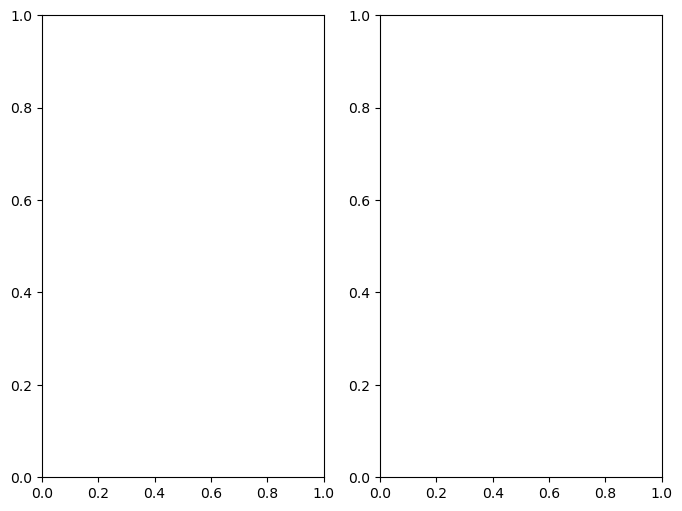

In [26]:
x_epochs = np.linspace(1, num_epochs, num_epochs)
fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
model.eval()
y_true = []
y_cls = []
with torch.no_grad():  # Disable gradient computation during validation
    for i, (x_minibatch, y_true_batch) in enumerate(test_loader):
        y_pred = model(x_minibatch)
        y_cls_batch = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
        y_true.append(y_true_batch.tolist())
        y_cls.append(y_cls_batch.tolist())
y_true = np.reshape(y_true, -1)
y_cls = np.reshape(y_cls, -1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       320
           1       0.00      0.00      0.00       224
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00         6

    accuracy                           0.50       640
   macro avg       0.12      0.25      0.17       640
weighted avg       0.25      0.50      0.33       640



/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
# class ConvNet(nn.Module):
#     def __init__(self, in_channels, nb_filters, kernel_size_conv, fc_size, fc_out_features, pooling_size = [1, 1], activation_function = F.relu, dropout_rate_conv = 0, dropout_rate_fc = 0, padding = 0, stride = 1):
#         '''
#         in_channels         : The dimension of colors (grayscale = 1, rbg = 3)
#         nb_filters          : Number of filters applied to first layer
#         kernel_size_conv    : Size of the convolution of the first layer
#         fc_size             : Size of the first fully connected layer (output)
#         fc_out_features     : Number of classes of the dataset
#         pooling_size        : Pooling size, default = (1,1)
#         activation_function : Set the activation function for the layers, default is ReLU
#         dropout_rate_cov    : Sets the probability for dropout rates in the convolutional layers , default = 0
#         dropout_rate_fc     : Sets the probability for dropout rates in the fully connected layers , default = 0
#         padding             : Size of padding that should be applied, default = 0
#         stride              : Size of the stride applied of the convolution, default = 1
#         '''

#         # Define layers in the network
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, nb_filters, kernel_size_conv)
#         self.dropout1 = nn.Dropout2d(p=dropout_rate_conv)
#         self.conv2 = nn.Conv2d(nb_filters, 2 * nb_filters, kernel_size_conv)
#         self.dropout2 = nn.Dropout2d(p=dropout_rate_conv)
#         self.conv3 = nn.Conv2d(2 * nb_filters,  4 *nb_filters, kernel_size_conv)
#         self.dropout3 = nn.Dropout2d(p=dropout_rate_conv)
#         self.conv4 = nn.Conv2d(4 * nb_filters, 8 * nb_filters, kernel_size_conv)
#         self.dropout4 = nn.Dropout2d(p=dropout_rate_conv)
#         self.conv5 = nn.Conv2d(8 * nb_filters, 16 * nb_filters, kernel_size_conv)
#         self.dropout5 = nn.Dropout2d(p=dropout_rate_conv)
#         self.pool = nn.MaxPool2d(pooling_size[0], pooling_size[1])
    
#         # Initialize these sizes for the fully connected layer and calculate this dynamically later in the first forward pass
#         self.input_size = None                  # Will later be the size of the image input
#         self.fc_size_input = None               # Will later be the size of the output of the last cnn layer (after pooling)

#         # Dummy values for Linear layers; will be updated in the first forward pass
#         self.fc1 = nn.Linear(1, 1)
#         self.fc2 = nn.Linear(1, 1)
#         self.fc3 = nn.Linear(1, 1)

#         # Dropout for fully connected layers
#         self.dropout_fc1 = nn.Dropout(p=dropout_rate_fc)
#         self.dropout_fc2 = nn.Dropout(p=dropout_rate_fc)

#         # Set some variables for the forward pass
#         self.activation_function = activation_function
#         self.fc_size = fc_size
#         self.fc_out_features = fc_out_features
#         self.pooling_size = pooling_size
#         self.padding = padding
#         self.stride = stride

#         # # Initialize the weights
#         # nn.init.xavier_uniform_(self.conv1.weight)
#         # nn.init.xavier_uniform_(self.conv2.weight)
#         # nn.init.xavier_uniform_(self.fc1.weight)
#         # nn.init.xavier_uniform_(self.fc2.weight)
#         # nn.init.xavier_uniform_(self.fc3.weight)


#     def forward(self, x):
#         # Set the input size dynamically during the first forward pass
#         if self.input_size is None:
#             self.input_size = x.size(2)
#             self.fc_size_input = self.calculate_fc_size(self.conv1.out_channels, self.conv1.kernel_size[0])
#             print(self.fc_size_input)
#             self.fc1 = nn.Linear(self.fc_size_input, self.fc_size)
#             self.fc2 = nn.Linear(self.fc_size, int(self.fc_size / 2))
#             self.fc3 = nn.Linear(int(self.fc_size / 2), self.fc_out_features)

#         x = self.pool(self.activation_function(self.dropout1(self.conv1(x))))
#         x = self.pool(self.activation_function(self.dropout2(self.conv2(x))))
#         x = self.pool(self.activation_function(self.dropout3(self.conv3(x))))
#         # x = self.pool(self.activation_function(self.dropout4(self.conv4(x))))
#         # x = self.pool(self.activation_function(self.dropout5(self.conv5(x))))
        
#         x = x.view(-1, self.fc_size_input)
#         x = self.activation_function(self.dropout_fc1(self.fc1(x)))
#         x = self.activation_function(self.dropout_fc2(self.fc2(x)))
#         x = self.fc3(x)
#         return x

#     def calculate_fc_size(self, nb_filters, kernel_size_conv):
#         # Calculate the dynamic input size for fully connected layer
#         conv_output_size1 = self.calculate_conv_output_size(self.input_size, kernel_size_conv)
#         pooled_output_1 = self.calculate_conv_output_size(conv_output_size1, self.pooling_size[0], stride=self.pooling_size[1])
#         conv_output_size2 = self.calculate_conv_output_size(pooled_output_1, kernel_size_conv)
#         pooled_output_2 = self.calculate_conv_output_size(conv_output_size2, self.pooling_size[0], stride=self.pooling_size[1])
#         conv_output_size3 = self.calculate_conv_output_size(pooled_output_2, kernel_size_conv)
#         pooled_output_3 = self.calculate_conv_output_size(conv_output_size3, self.pooling_size[0], stride=self.pooling_size[1])
#         # conv_output_size4 = self.calculate_conv_output_size(pooled_output_3, kernel_size_conv)
#         # pooled_output_4 = self.calculate_conv_output_size(conv_output_size4, self.pooling_size[0], stride=self.pooling_size[1])
#         # conv_output_size5 = self.calculate_conv_output_size(pooled_output_4, kernel_size_conv)
#         # pooled_output_5 = self.calculate_conv_output_size(conv_output_size5, self.pooling_size[0], stride=self.pooling_size[1])
#         # fc_size = 16 * nb_filters * pooled_output_5**2
#         fc_size = 4 * nb_filters * pooled_output_3**2
#         return fc_size

#     def calculate_conv_output_size(self, input_size, kernel_size, stride = 1):
#         # Calculate the output size of the convolutional layer
#         return int(np.floor((input_size - kernel_size + 2 * self.padding) / stride) + 1)


# model = ConvNet(in_channels=1, nb_filters=6, kernel_size_conv=8, fc_size = 512, fc_out_features=num_classes, pooling_size=[2,2], dropout_rate_conv=0.2, dropout_rate_fc=0.2)
# model.train()

# criterion = nn.CrossEntropyLoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# n_total_steps = train_loader.__len__()
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader):
#         images = images.float()
#         images = images.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if ((i+1) % (n_total_steps // 2) == 0):
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
#             model.eval()
#             y_pred = F.softmax(model(images), dim=1)
#             y_pred = torch.argmax(y_pred, dim=1)
#             print(f'Accuracy on validation set: {accuracy_score(labels, y_pred)}')
#             model.train()

# print('Finished Training')
# PATH = './cnn.pth'
# torch.save(model.state_dict(), PATH)


# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     n_class_correct = [0 for i in range(num_classes)]
#     n_class_samples = [0 for i in range(num_classes)]
#     for images, labels in test_loader:
#         images = images.float()
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         # max returns (value ,index)
#         _, predicted = torch.max(F.softmax(outputs), 1)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels).sum().item()
        
#         for i in range(batch_size):
#             label = labels[i]
#             pred = predicted[i]
#             if (label == pred):
#                 n_class_correct[label] += 1
#             n_class_samples[label] += 1

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network: {acc} %')

#     for i in range(num_classes):
#         acc = 100.0 * n_class_correct[i] / n_class_samples[i]
#         print(f'Accuracy of {classes[i]}: {acc} %')

# print()
# model.eval()
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     n_class_correct = [0 for i in range(num_classes)]
#     n_class_samples = [0 for i in range(num_classes)]
#     for images, labels in test_loader:
#         images = images.float()
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         # max returns (value ,index)
#         _, predicted = torch.max(outputs, 1)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels).sum().item()
        
#         for i in range(batch_size):
#             label = labels[i]
#             pred = predicted[i]
#             if (label == pred):
#                 n_class_correct[label] += 1
#             n_class_samples[label] += 1

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network in eval mode: {acc} %')

#     for i in range(num_classes):
#         acc = 100.0 * n_class_correct[i] / n_class_samples[i]
#         print(f'Accuracy of {classes[i]}: {acc} %')
